<a href="https://colab.research.google.com/github/TypicalDefender/recommendation-system/blob/master/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

Capstone Project For Recommendation System. By Shivangi Nagaich

In [0]:
from google.colab import files

uploaded = files.upload()

Saving shared_articles.csv to shared_articles.csv


In [0]:
import io
articles_df = pd.read_csv(io.StringIO(uploaded['shared_articles.csv'].decode('utf-8')))
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


Contains information about the articles shared in the platform. Each article has its sharing date (timestamp), the original url, title, content in plain text, the article' lang (Portuguese: pt or English: en) and information about the user who shared the article (author).

There are two possible event types at a given timestamp:

CONTENT SHARED: The article was shared in the platform and is available for users.
CONTENT REMOVED: The article was removed from the platform and not available for further recommendation.
For the sake of simplicity, we only consider here the "CONTENT SHARED" event type, assuming (naively) that all articles were available during the whole one year period.

In [0]:
from google.colab import files

uploaded = files.upload()

Saving users_interactions.csv to users_interactions.csv


In [0]:
interactions_df = pd.read_csv(io.StringIO(uploaded['users_interactions.csv'].decode('utf-8')))
interactions_df.head(2)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


Contains logs of user interactions on shared articles. It can be joined to articles_shared.csv by contentId column.

The eventType values are:

VIEW: The user has opened the article.
LIKE: The user has liked the article.
COMMENT CREATED: The user created a comment in the article.
FOLLOW: The user chose to be notified on any new comment in the article.
BOOKMARK: The user has bookmarked the article for easy return in the future.

In [0]:
#data munging
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

As there are different interactions types, we associate them with a weight or strength, assuming that, for example, a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [0]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


Recommender systems have a problem known as user cold-start, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.
For this reason, we are keeping in the dataset only users with at leas 5 interactions.

In [0]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


In [0]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


 users are allowed to view an article many times, and interact with them in different ways (eg. like or comment). Thus, to model the user interest on a given article, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [0]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


**Evaluation**
We are using here a simple cross-validation approach named holdout, in which a random data sample (20% in this case) are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the test set.

Ps. A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this notebook, but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

In [0]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')


In [0]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [0]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()  

In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.
This evaluation method works as follows:

For each user
For each item the user has interacted in test set
Sample 100 other items the user has never interacted.
Ps. Here we naively assume those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption.
Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted ("non-relevant!) items
Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
Aggregate the global Top-N accuracy metrics
The Top-N accuracy metric choosen was Recall@N which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.
Ps. Other popular ranking metrics are NDCG@N and MAP@N, whose score calculation takes into account the position of the relevant item in the ranked list (max. value if relevant item is in the first position).

In [0]:
#popularity model
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [0]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)


In [0]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2417540271030427, 'recall@10': 0.37292252620813093}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,50,28,192,0.260417,0.145833
17,-2626634673110551643,25,12,134,0.186567,0.089552
16,-1032019229384696495,23,13,130,0.176923,0.100000
10,-1443636648652872475,9,5,117,0.076923,0.042735
82,-2979881261169775358,40,25,88,0.454545,0.284091
161,-3596626804281480007,18,12,80,0.225000,0.150000
65,1116121227607581999,33,20,73,0.452055,0.273973
81,692689608292948411,23,17,69,0.333333,0.246377
106,-9016528795238256703,18,14,69,0.260870,0.202899
52,3636910968448833585,28,21,68,0.411765,0.308824


In [0]:
import nltk
nltk.download('stopwords')
#content based filtering
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [0]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [0]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [0]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.305655
1,machine learning,0.255557
2,machine,0.246095
3,google,0.208590
4,data,0.172509
5,ai,0.136818
6,algorithms,0.102396
7,graph,0.098438
8,like,0.096970
9,language,0.083993


In [0]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

In [0]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.41459984658655075, 'recall@10': 0.5241626182562005}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,26,16,192,0.135417,0.083333
17,-2626634673110551643,35,21,134,0.261194,0.156716
16,-1032019229384696495,34,22,130,0.261538,0.169231
10,-1443636648652872475,54,34,117,0.461538,0.290598
82,-2979881261169775358,15,8,88,0.170455,0.090909
161,-3596626804281480007,23,14,80,0.287500,0.175000
65,1116121227607581999,15,10,73,0.205479,0.136986
81,692689608292948411,20,11,69,0.289855,0.159420
106,-9016528795238256703,10,5,69,0.144928,0.072464
52,3636910968448833585,11,4,68,0.161765,0.058824


In [0]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,-9153494109165200346,-9147114693160126293,-9137036168156595470,-9128741757954228992,-9128652074338368262,-9107331682787867601,-9105040345021932755,-9103776596534246502,-9102431381393428051,-9100490342054218852,-9099155556042679205,-9095002324981651252,-9092333155845304874,-9090514312860140897,-9089854794058353436,-9086955082453789880,-9083294960368598209,-9081753261356157170,-9080873096647717414,-9076501258717815738,-9073210245497295284,-9071883412530082330,-9064100704535292718,-9056114023474725450,-9055044275358686874,-9050450867630628092,-9045753673721269477,...,8962537427807366481,8963770574956550187,8963938873430212934,8968837261991914049,8969476626572775042,8974280745225397183,8982094176562780806,8993230615635349817,9004099881383415529,9026402401132606773,9028580484484026894,9032993320407723266,9033884391004475493,9038543365726770177,9042192299854648021,9045808098977760576,9054050762437897017,9056727675613132316,9060231864899459154,9079880752026843473,9091641298512813712,9112765177685685246,9121100366909552616,9122627895188486603,9124439338148818380,9128267824356972069,9136323715291453594,9151634133568930081,9168028029170358424,9175693555063886126,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.321928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [0]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [0]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [0]:
U.shape

(1140, 15)

In [0]:
Vt.shape

(15, 2926)

In [0]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [0]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [-0.02995379,  0.00805715, -0.01846307, ..., -0.01083078,
        -0.00118591,  0.0096798 ],
       [-0.01845505,  0.00467019,  0.01219602, ...,  0.00409507,
         0.00019482, -0.00752562],
       [-0.01506374,  0.00327732,  0.13391269, ..., -0.01191815,
         0.06422074,  0.01303244]])

In [0]:
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,-9063420486253202900,-9060214117327732109,-9047547311469006438,-9016528795238256703,-9009798162809551896,-9001583565812478106,-8994220765455693336,-8909668725653743114,-8891033171626175843,-8860671864164757449,-8854674432071487111,-8853658195208337106,-8845298781299428018,-8830250090736356260,-8823950498314351783,-8802075878443651241,-8784674845716296727,-8781635134606732409,-8781306637602263252,-8763398617720485024,-8738496712327699923,-8719462623048086192,-8704807962619440953,-8699750646678621887,-8694104221113176052,-8686631410634491662,-8674958742744576254,-8672331451814079632,-8670749047273764903,-8652741825481604192,...,8791271631167250981,8801420707973230165,8801970869404590779,8813266398846460512,8841741572929644986,8847054836611412804,8855523843512271162,8862260182894039021,8872819156169667456,8874741321583329336,8879844298911979276,8892482595912468268,8907499588729810535,8913362709216003291,8920667914865172372,8940614478925413056,8941502917401491878,8961723342122872302,8965285988346645117,8968131284214320024,8982783231149017560,8992729171160464416,9013651444868609421,9033898219489253274,9037410398700100618,9038446466275805109,9050204922960952289,9090527742744334314,9091970136990402395,9102085903669288476,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.010399,-0.000193,-0.012547,0.052958,-0.010035,-0.005412,-0.003918,0.049302,-0.013458,-0.020052,-0.009529,0.001567,-0.012044,-0.065134,0.112747,0.041108,-0.010481,-0.005297,-0.034884,-0.123017,-0.008897,-0.042487,0.416457,-0.033627,-0.003643,-0.000428,-0.007387,-0.007513,0.006235,0.058278,-0.028610,0.042954,0.000090,-0.008141,0.134043,-0.003323,0.032243,-0.033136,-0.039186,0.001904,...,0.000177,0.020430,-0.018576,0.023053,-0.024097,-0.007354,0.013645,-0.018282,-0.014919,-0.009511,-0.019433,0.000082,-0.003258,-0.002602,0.004572,-0.017065,0.001240,-0.001879,-0.002489,0.510757,-0.007451,-0.018229,-0.004900,-0.009748,0.002856,0.003318,-0.007141,-0.006217,0.009393,0.030966,-0.005306,-0.089463,-0.000048,0.015023,0.020953,-0.009394,-0.019114,-0.029954,-0.018455,-0.015064
-9216926795620865886,0.000819,-0.000313,0.006595,-0.000649,0.000151,0.000338,0.000197,0.000861,0.002341,0.001765,0.000693,-0.000401,-0.001323,0.016495,0.009792,0.005556,0.004797,0.001999,0.008558,0.036923,0.005375,0.019304,-0.009210,-0.000040,0.000914,0.000683,0.001836,0.000193,0.003247,0.009282,0.001267,0.003316,-0.000087,0.007292,0.001487,0.000276,0.009248,0.006766,0.009996,-0.000612,...,0.000489,0.001326,0.000265,0.002428,0.002844,-0.001767,0.003285,0.004587,0.005100,-0.000124,0.004198,0.001862,0.001347,-0.000930,0.016121,0.003219,0.001562,0.002164,0.000682,0.024945,-0.000414,0.002806,-0.000472,0.002431,-0.000802,0.002470,0.000775,-0.000109,0.001362,-0.000543,0.000095,0.013915,0.000506,0.001460,0.014863,0.000940,0.002391,0.008057,0.004670,0.003277
-9194572880052200111,-0.017253,-0.002646,-0.005907,-0.003666,0.021300,-0.001278,0.029100,-0.014730,-0.023410,0.004950,0.025522,0.006706,0.016231,-0.085721,0.058917,0.029974,-0.002729,0.012110,-0.002258,0.015465,-0.002322,0.162668,-0.110257,0.043068,0.003892,0.002378,0.020120,-0.000989,0.095824,0.079587,-0.014877,0.033582,0.004351,0.023526,-0.057510,0.005366,0.082665,0.016139,0.079913,0.022207,...,-0.000575,0.013275,-0.005904,-0.010228,0.013855,0.016897,0.077516,-0.003531,0.044262,0.015127,0.057267,0.032941,0.011972,0.009667,0.005471,-0.022793,0.011801,0.001594,-0.002086,0.106361,0.000542,0.012707,-0.007648,-0.001696,-0.001347,0.020591,0.005007,0.001418,0.016003,-0.010067,0.011529,0.046012,0.010485

In [0]:
len(cf_preds_df.columns)

1140

In [0]:

class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [0]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.33405778573254924, 'recall@10': 0.46816670928151366}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,45,21,192,0.234375,0.109375
17,-2626634673110551643,56,30,134,0.417910,0.223881
16,-1032019229384696495,34,16,130,0.261538,0.123077
10,-1443636648652872475,51,38,117,0.435897,0.324786
82,-2979881261169775358,48,39,88,0.545455,0.443182
161,-3596626804281480007,34,22,80,0.425000,0.275000
65,1116121227607581999,32,24,73,0.438356,0.328767
81,692689608292948411,21,16,69,0.304348,0.231884
106,-9016528795238256703,28,20,69,0.405797,0.289855
52,3636910968448833585,30,23,68,0.441176,0.338235


In [0]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)

In [0]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.4337765277422654, 'recall@10': 0.537969828688315}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,40,27,192,0.208333,0.140625
17,-2626634673110551643,56,38,134,0.417910,0.283582
16,-1032019229384696495,35,27,130,0.269231,0.207692
10,-1443636648652872475,52,37,117,0.444444,0.316239
82,-2979881261169775358,31,26,88,0.352273,0.295455
161,-3596626804281480007,28,20,80,0.350000,0.250000
65,1116121227607581999,21,16,73,0.287671,0.219178
81,692689608292948411,23,14,69,0.333333,0.202899
106,-9016528795238256703,19,14,69,0.275362,0.202899
52,3636910968448833585,19,16,68,0.279412,0.235294


In [0]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularity,0.372923,0.241754
Collaborative Filtering,0.468167,0.334058
Content-Based,0.524163,0.414600
Hybrid,0.537970,0.433777


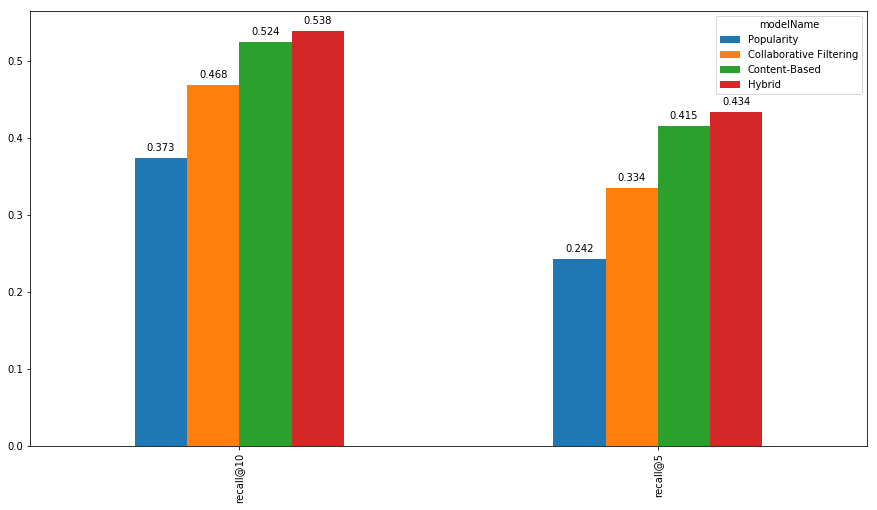

In [0]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [0]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

In [0]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
115,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
38,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
8,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
116,3.954196,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
10,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
28,3.700440,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
6,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
113,3.643856,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
42,3.523562,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
43,3.459432,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en


In [0]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,0.484696,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
1,0.428711,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
2,0.411263,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
3,0.358686,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en
4,0.335053,5250363310227021277,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
5,0.316371,-7126520323752764957,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
6,0.316029,7395435905985567130,The AI business landscape,https://www.oreilly.com/ideas/the-ai-business-...,en
7,0.309052,-5756697018315640725,Being A Developer After 40 - Free Code Camp,https://medium.freecodecamp.com/being-a-develo...,en
8,0.295994,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
9,0.294210,1415230502586719648,Machine Learning Is Redefining The Enterprise ...,http://www.forbes.com/sites/louiscolumbus/2016...,en
